In [12]:
import numpy as np
import hydra
import torch
import pickle
import matplotlib.pyplot as plt
from omegaconf import OmegaConf

from pytorch_lightning import (
    LightningDataModule,
    seed_everything,
)

import umap
from sklearn.decomposition import PCA

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from tqdm import tqdm

from utils import *
from multimodal_contrastive.utils import utils
from gflownet.envs.frag_mol_env import FragMolBuildingEnvContext, _recursive_decompose

# register custom resolvers if not already registered
OmegaConf.register_new_resolver("sum", lambda input_list: np.sum(input_list), replace=True)

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [13]:
# Load config for CLIP model
config_name = "puma_sm_gmc"
configs_path = "../../configs"

with hydra.initialize(version_base=None, config_path=configs_path):
    cfg = hydra.compose(config_name=config_name)

cfg.datamodule.split_type

'shuffled_scaffold'

In [14]:
# Set seed for random number generators in pytorch, numpy and python.random
# and especially for generating the same data splits for the test set
if cfg.get("seed"):
    seed_everything(cfg.seed, workers=True)

# Load test data split
datamodule: LightningDataModule = hydra.utils.instantiate(cfg.datamodule)
datamodule.setup("test")

Train on samples from shuffled_scaffold.
Train on 13582 samples.
Validate on 1698 samples.
Test on 1698 samples.


In [15]:
# Load model from checkpoint
ckpt_path = "/home/mila/s/stephen.lu/gfn_gene/res/mmc/models/morph_struct_90_step_val_loss.ckpt"
model = utils.instantiate_model(cfg)
model = model.load_from_checkpoint(ckpt_path, map_location=device)
model = model.eval()

# Get latent representations for full dataset
representations = model.compute_representation_dataloader(
    make_eval_data_loader(datamodule.dataset),
    device=device,
    return_mol=False
)

INFO:root:Instantiating torch.nn.module JointEncoder
INFO:root:Instantiating lightning model <multimodal_contrastive.networks.models.GMC_PL>
/home/mila/s/stephen.lu/miniconda3/envs/gfn/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:196: UserWarning: Attribute 'encoder_joint' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['encoder_joint'])`.
  rank_zero_warn(
/home/mila/s/stephen.lu/miniconda3/envs/gfn/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:196: UserWarning: Attribute 'common_encoder' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['common_encoder'])`.
  rank_zero_warn(
100%|██████████| 133/133 [01:03<00:00,  2.11it/s]


In [16]:
# Setup a frag building environment, so that we can use the mol_to_graph() function to attempt to 
# factorize the molecules in the puma dataset into their constituent fragments
env = FragMolBuildingEnvContext()

def mol_to_graph(environ, mol):
    """Convert an RDMol to a Graph"""
    assert type(mol) is Chem.Mol
    all_matches = {}
    for fragidx, frag in environ.sorted_frags:
        all_matches[fragidx] = mol.GetSubstructMatches(frag, uniquify=False)
    return _recursive_decompose(environ, mol, all_matches, {}, [], [], 10)

In [17]:
def go(dataset):
    decomposed_samples = {}
    for idx, sample in enumerate(tqdm(dataset)):
        smiles = sample["inputs"]["struct"].mols
        mol = Chem.MolFromSmiles(smiles)
        try:
            g = env.mol_to_graph(mol)
            if g != None:
                print(idx, f"Factorized with {g.number_of_nodes()} nodes.")
                decomposed_samples[idx] = (sample, g)
        except ValueError as e:
            continue
    return decomposed_samples

In [19]:
# decomposed_samples = go(datamodule.dataset)
# # save the samples that were successfully factorized
# with open(f"decomposed_samples_puma.pkl", "wb") as f:
#     pickle.dump(decomposed_samples, f)

# or load from file
with open("/home/mila/s/stephen.lu/gfn_gene/res/mmc/data/decomposed_samples_puma.pkl", "rb") as f:
    decomposed_samples = pickle.load(f)

# # convert to a dictionary indexed by the sample index
# decomposed_samples = {idx: (sample, graph) for idx, sample, graph in decomposed_samples}

In [11]:
import pandas as pd

df = pd.DataFrame(columns=["smiles"])
for idx, (sample, graph) in decomposed_samples.items():
    df.loc[idx] = {"smiles": sample["inputs"]["struct"].mols}

df.to_csv("decomposed_samples_puma.csv")

In [20]:
# keep the decomposed_samples that also happen to be apart of the test split
train_idx, val_idx, test_idx = datamodule.get_split_idx()
test_decomposed_samples = {idx: (sample, graph) for idx, (sample, graph) in decomposed_samples.items() if idx in test_idx}
len(test_decomposed_samples)

2

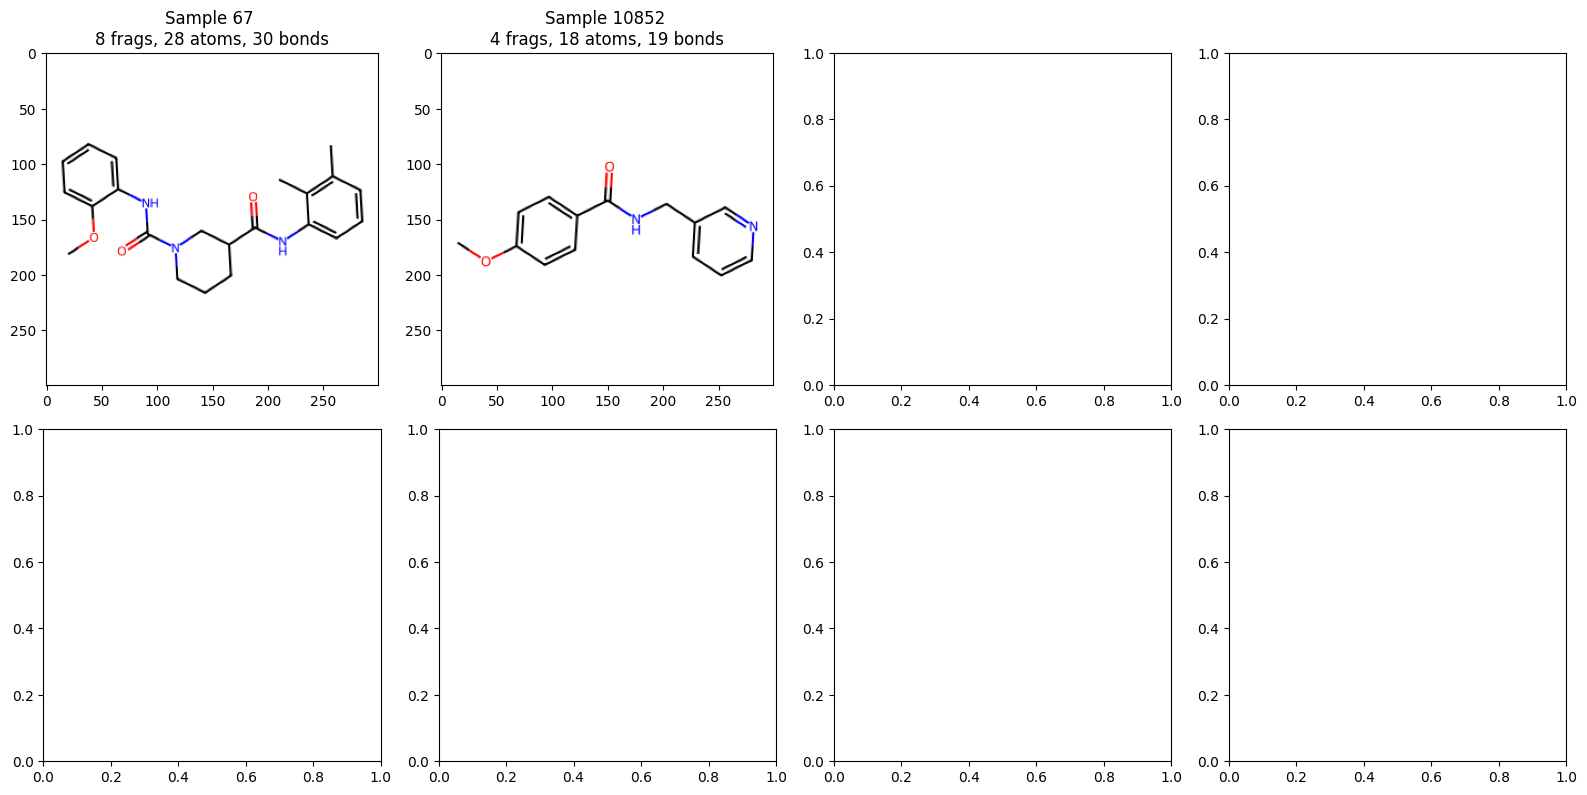

In [56]:
# Visualize a the samples that were factorized from the test set
fig, ax = plt.subplots(2, 4, figsize=(16, 8))
some_samples = list(test_decomposed_samples.keys())[:8]

for idx, sample_idx in enumerate(some_samples):
    sample, g = test_decomposed_samples[sample_idx]
    smiles = sample["inputs"]["struct"].mols
    mol = Chem.MolFromSmiles(smiles)
    img = Draw.MolToImage(mol)
    n_atoms = mol.GetNumAtoms()
    n_bonds = mol.GetNumBonds()
    
    ax[idx//4, idx%4].imshow(img)
    ax[idx//4, idx%4].set_title(f"Sample {sample_idx} \n{g.number_of_nodes()} frags, {n_atoms} atoms, {n_bonds} bonds")

plt.tight_layout()

In [ ]:
# Plot the umap of raw morph features of the entire dataset and plot the factorized sample
# morph features on top of it in a different color

factorized_idx = list(decomposed_samples.keys())
fact_morph = np.array([x[0]["inputs"]["morph"].numpy() for x in decomposed_samples.values()])

non_factorized_idx = np.random.choice(range(len(datamodule.dataset)), size=2000, replace=False)
non_fact_morph = np.array([datamodule.dataset[i]["inputs"]["morph"].numpy() for i in non_factorized_idx])

n_neighbors = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
fig, ax = plt.subplots(2, 5, figsize=(20, 10))

for idx, n in enumerate(n_neighbors):
    print(idx)
    reducer = umap.UMAP(n_neighbors=n, random_state=42, verbose=True)
    embedding = reducer.fit_transform(non_fact_morph)
    fact_embedding = reducer.transform(fact_morph)

    ax[idx//5, idx%5].scatter(embedding[:, 0], embedding[:, 1], s=1, c="blue", alpha=0.5, label="non-factorized")
    ax[idx//5, idx%5].scatter(fact_embedding[:, 0], fact_embedding[:, 1], s=1, c="red", alpha=0.5, label="factorized")
    ax[idx//5, idx%5].set_title(f"n_neighbors={n}")
    ax[idx//5, idx%5].legend()

plt.show()

In [ ]:
pca = PCA(n_components=2)

non_fact_morph_pca = pca.fit_transform(non_fact_morph)
fact_morph_pca = pca.transform(fact_morph)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.scatter(non_fact_morph_pca[:, 0], non_fact_morph_pca[:, 1], c="blue", label="Non-factorized")
ax.scatter(fact_morph_pca[:, 0], fact_morph_pca[:, 1], c="red", label="Factorized")

ax.legend()
plt.show()

In [11]:
# Get pca morph representations with k=30 components for all samples
pca = PCA(n_components=30)
morph = np.array([sample["inputs"]["morph"].numpy() for sample in tqdm(datamodule.dataset)])
morph_pca = pca.fit_transform(morph)
print(morph_pca.shape)

100%|██████████| 16978/16978 [01:25<00:00, 198.17it/s]


(16978, 30)


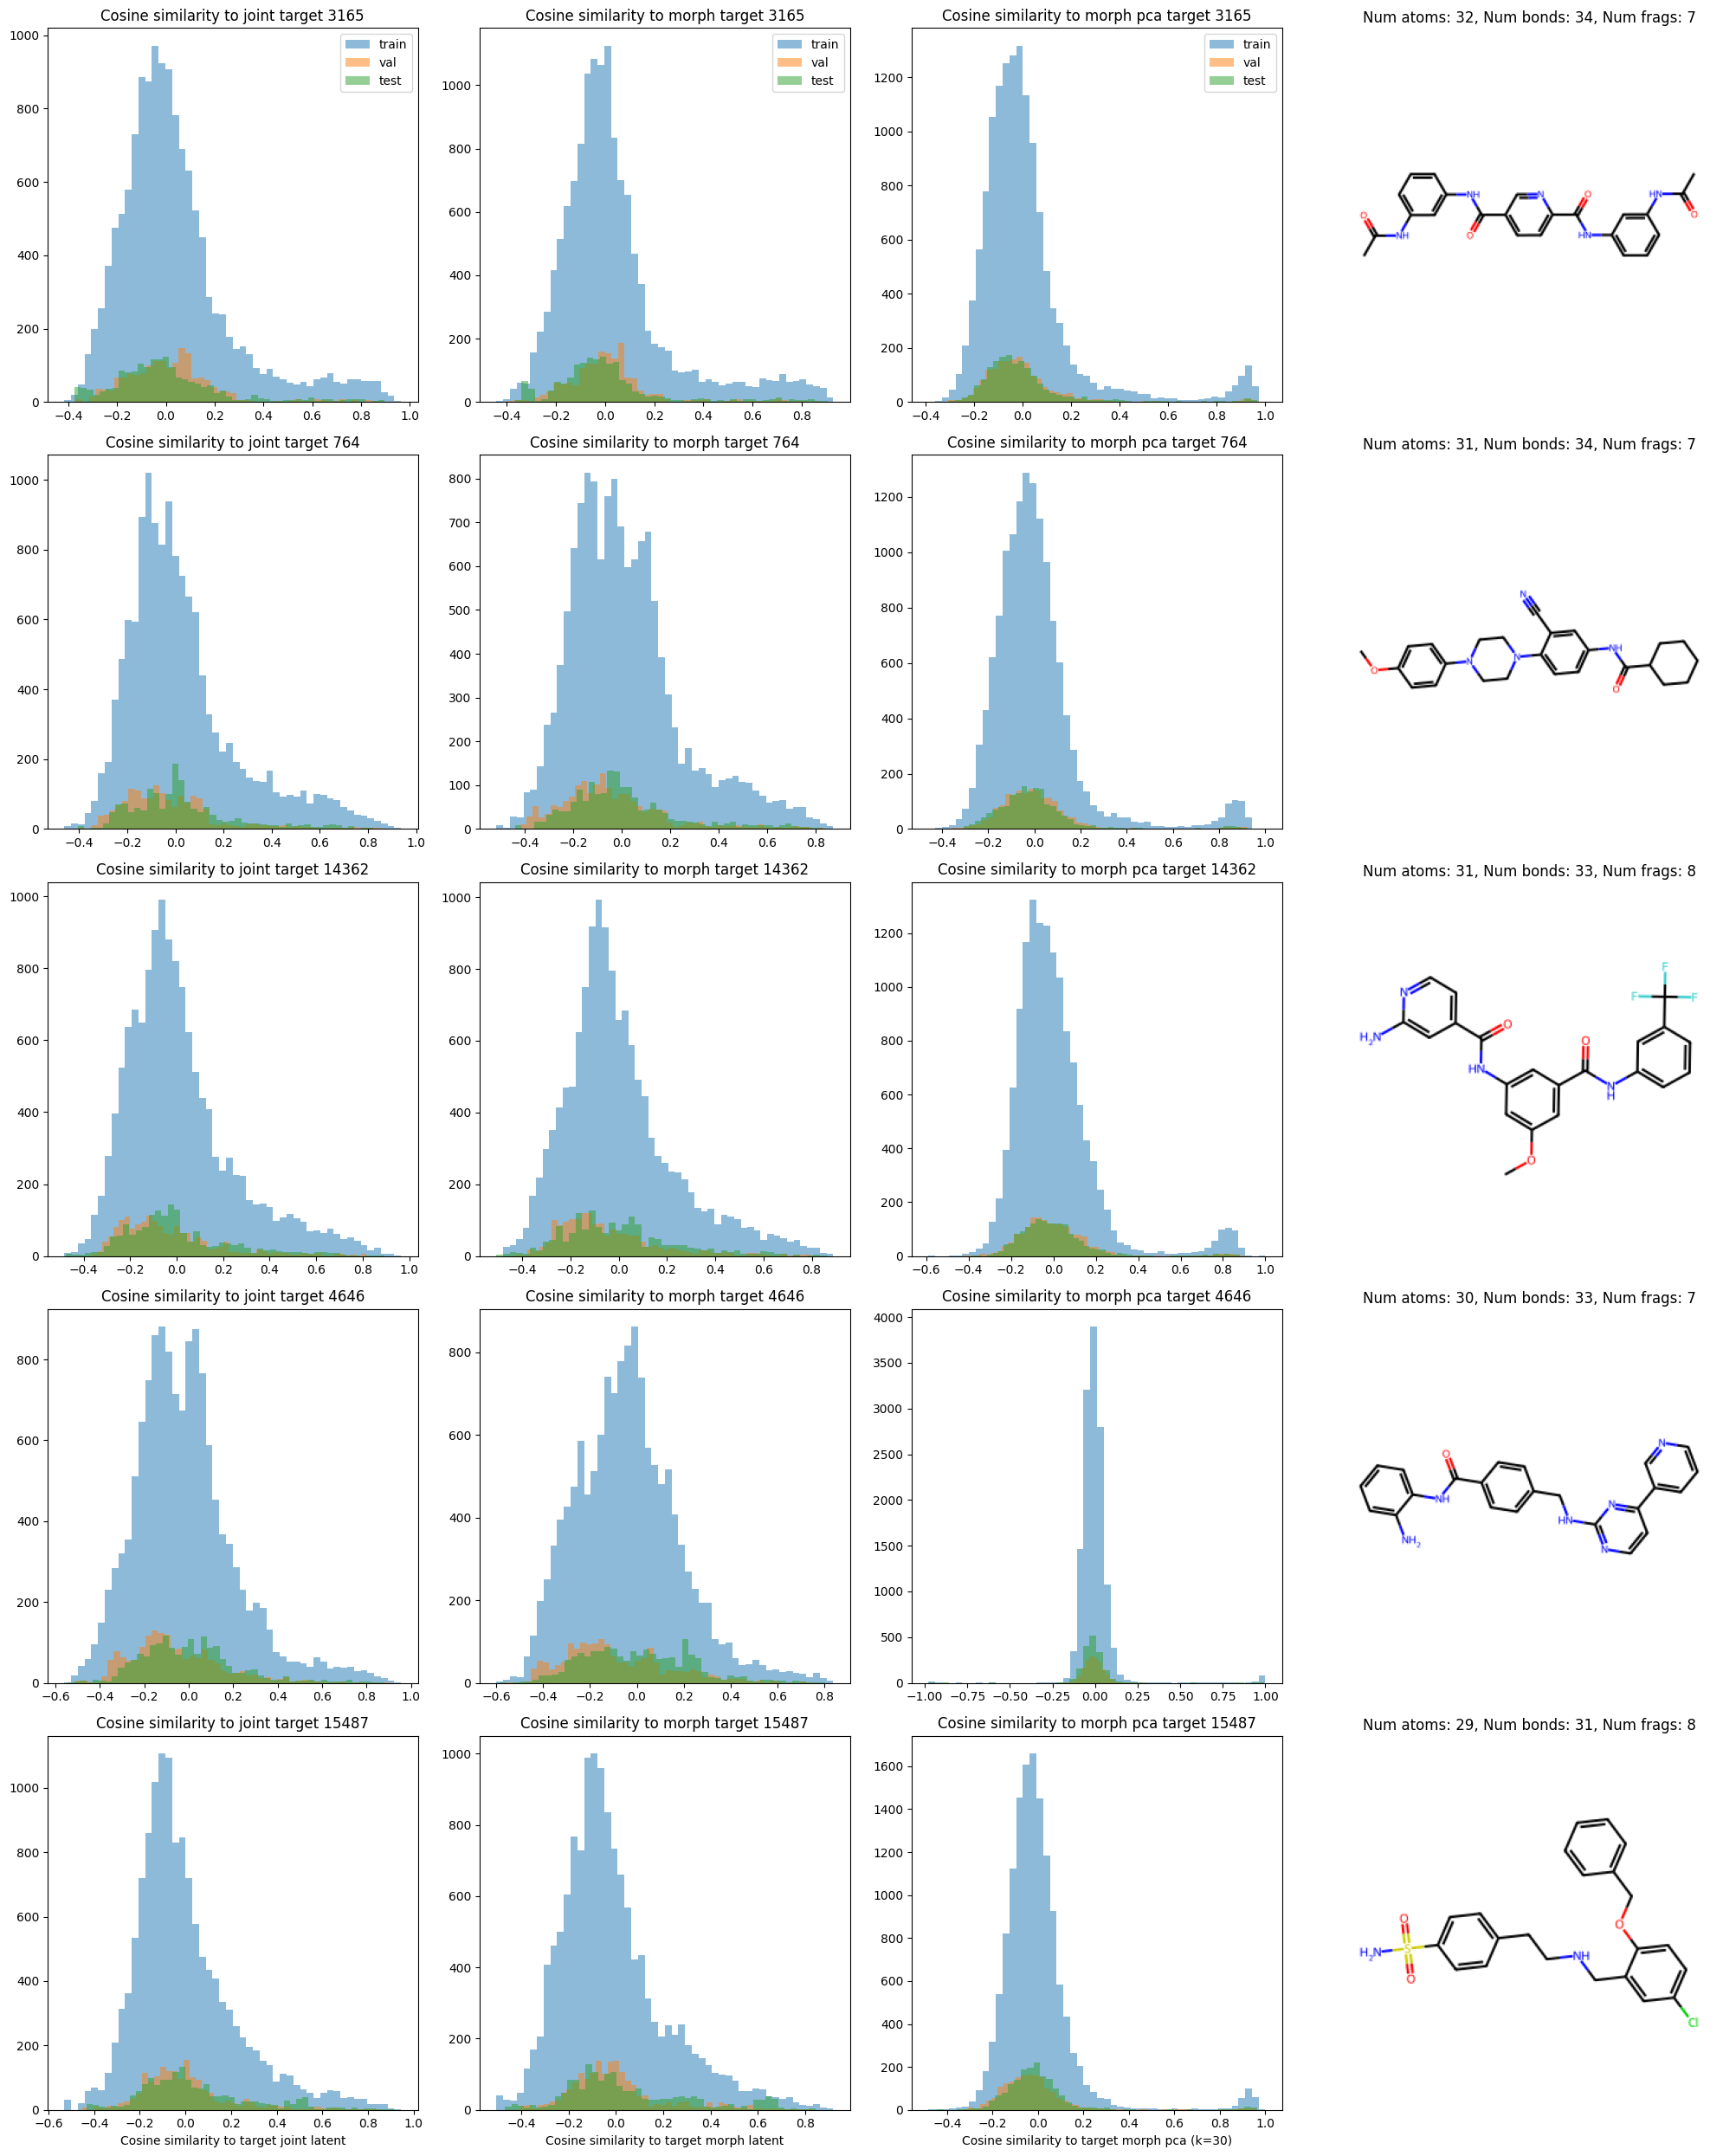

In [13]:
struct_latents = {
    "train": representations['struct'][train_idx],
    "val": representations['struct'][val_idx],
    "test": representations['struct'][test_idx]
}

morph_pca_lib = {
    "train": morph_pca[train_idx],
    "val": morph_pca[val_idx],
    "test": morph_pca[test_idx]
}

# target_indices = list(decomposed_samples.keys())
# target_indices = np.random.choice(target_indices, size=5, replace=False)
target_indices = [3165, 764, 14362, 4646, 15487]
n_targets = len(target_indices)

fig, ax = plt.subplots(n_targets, 4, figsize=(20, 5*n_targets))

for i in range(n_targets):
    # get a random target molecule and its latent representations
    target_idx = target_indices[i]
    sample, graph = decomposed_samples[target_idx][0], decomposed_samples[target_idx][1]
    
    target_joint_latent = representations['joint'][target_idx]
    target_morph_latent = representations['morph'][target_idx]

    for j, split in enumerate(["train", "val", "test"]):        
        # compute cosine similarity between target and all struct latents
        cosine_sim_joint = cosine_similarity([target_joint_latent], struct_latents[split])
        cosine_sim_morph = cosine_similarity([target_morph_latent], struct_latents[split])
        cosine_sim_morph_pca = cosine_similarity(morph_pca[target_idx].reshape(1, -1), morph_pca_lib[split])

        # plot histogram of cosine sim
        ax[i, 0].hist(cosine_sim_joint.flatten(), bins=50, alpha=0.5, label=split)
        ax[i, 1].hist(cosine_sim_morph.flatten(), bins=50, alpha=0.5, label=split)
        ax[i, 2].hist(cosine_sim_morph_pca.flatten(), bins=50, alpha=0.5, label=split)

    ax[i, 0].set_title(f"Cosine similarity to joint target {target_idx}")
    ax[i, 1].set_title(f"Cosine similarity to morph target {target_idx}")
    ax[i, 2].set_title(f"Cosine similarity to morph pca target {target_idx}")

    # plot the target molecule
    smiles = sample["inputs"]["struct"].mols
    mol = Chem.MolFromSmiles(smiles)
    img = Draw.MolToImage(mol)
    
    num_atoms = mol.GetNumAtoms()
    num_bonds = mol.GetNumBonds()

    ax[i, 3].set_title(f"Num atoms: {num_atoms}, Num bonds: {num_bonds}, Num frags: {graph.number_of_nodes()}")
    ax[i, 3].imshow(img)
    ax[i, 3].axis("off")

    # with open(f"sample_{target_idx}.pkl", "wb") as f:
    #     pickle.dump(sample, f)
    
    # with open(f"sample_{target_idx}.txt", "wb") as f:
    #     f.write(smiles)

ax[0, 0].legend()
ax[0, 1].legend()
ax[0, 2].legend()

ax[n_targets-1, 0].set_xlabel("Cosine similarity to target joint latent")
ax[n_targets-1, 1].set_xlabel("Cosine similarity to target morph latent")
ax[n_targets-1, 2].set_xlabel("Cosine similarity to target morph pca (k=30)")

# plt.savefig("target_analysis_final.png")
plt.tight_layout()
plt.show()

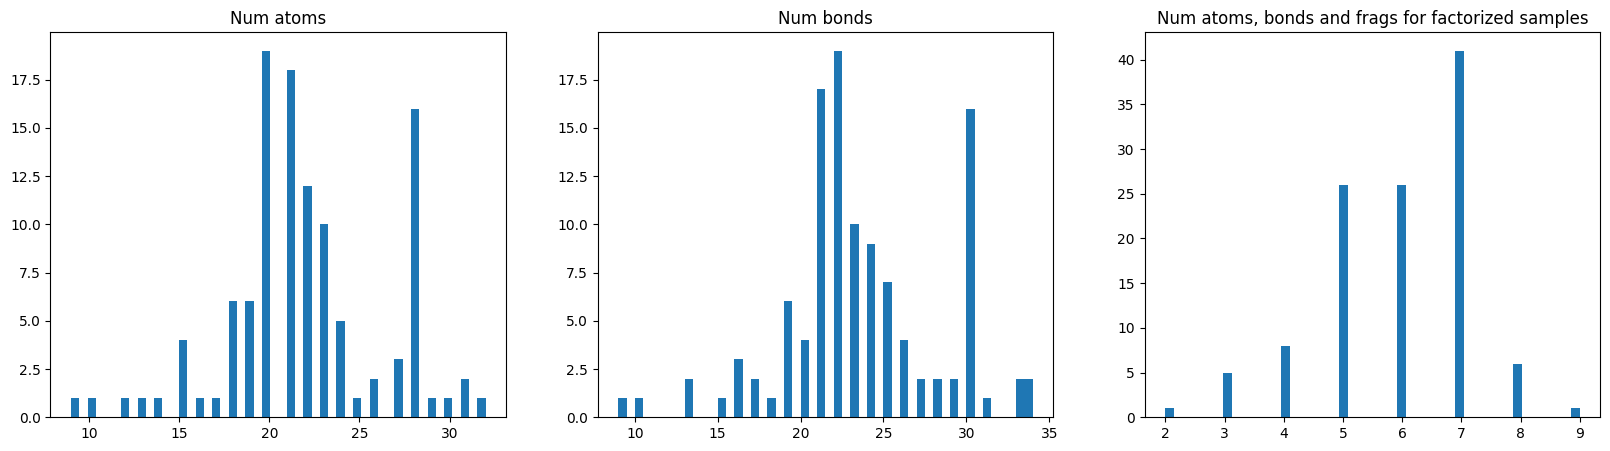

In [21]:
# Get the number of atoms for each factorized sample and plot histogram
num_atoms = []
num_bonds = []
num_frags = []
sample_idxs = []

for idx, sample_idx in enumerate(decomposed_samples.keys()):
    sample, graph = decomposed_samples[sample_idx]
    smiles = sample["inputs"]["struct"].mols
    mol = Chem.MolFromSmiles(smiles)
    sample_idxs.append(sample_idx)
    num_atoms.append(mol.GetNumAtoms())
    num_bonds.append(mol.GetNumBonds())
    num_frags.append(graph.number_of_nodes())

fig, ax = plt.subplots(1, 3, figsize=(20, 5))

ax[0].hist(num_atoms, bins=50)
ax[0].set_title("Num atoms")

ax[1].hist(num_bonds, bins=50)
ax[1].set_title("Num bonds")

ax[2].hist(num_frags, bins=50)
ax[2].set_title("Num frags")

plt.title("Num atoms, bonds and frags for factorized samples")
plt.show()

In [22]:
# print the index of samples with the highest number of atoms and bonds
sorted_by_atoms = sorted(zip(sample_idxs, num_atoms), key=lambda x: x[1], reverse=True)
sorted_by_bonds = sorted(zip(sample_idxs, num_bonds), key=lambda x: x[1], reverse=True)
sorted_by_frags = sorted(zip(sample_idxs, num_frags), key=lambda x: x[1], reverse=True)

print([x[0] for x in sorted_by_atoms[:5]])
print([x[0] for x in sorted_by_bonds[:5]])
print([x[0] for x in sorted_by_frags[:5]])

[3165, 764, 14362, 4646, 15487]
[764, 3165, 4646, 14362, 15487]
[15624, 67, 8826, 8900, 9883]


In [23]:
keys = [10852]

for sample_idx in keys:
    # assert sample_idx in test_idx
    sample = datamodule.dataset[sample_idx]
    struct_latent = representations['struct'][sample_idx]
    morph_latent = representations['morph'][sample_idx]
    joint_latent = representations['joint'][sample_idx]
    
    print(
        sample_idx,
        cosine_similarity(struct_latent.reshape(1, -1), morph_latent.reshape(1, -1)),
        cosine_similarity(struct_latent.reshape(1, -1), joint_latent.reshape(1, -1)),
        cosine_similarity(morph_latent.reshape(1, -1), joint_latent.reshape(1, -1))
    )

10852 [[0.7284244]] [[0.74304384]] [[0.78672343]]


In [18]:
sample, graph = decomposed_samples[3165]
sample_prime = datamodule.dataset[3165]

print(sample_prime)
print(sample)
print(graph)
# mol = Chem.MolFromSmiles(sample["inputs"]["struct"].mols)

# # plot molecule
# img = Draw.MolToImage(mol)
# plt.imshow(img)

OrderedDict([('inputs', OrderedDict([('struct', Data(x=[32, 133], edge_index=[2, 68], edge_attr=[68, 12], mols=[56])), ('morph', tensor([ 0.0040,  0.0023, -0.0341,  ..., -0.0473,  0.0072,  0.0050])), ('joint', OrderedDict([('struct', Data(x=[32, 133], edge_index=[2, 68], edge_attr=[68, 12], mols=[56])), ('morph', tensor([ 0.0040,  0.0023, -0.0341,  ..., -0.0473,  0.0072,  0.0050]))]))])), ('labels', tensor([-1.]))])
OrderedDict([('inputs', OrderedDict([('struct', Data(x=[32, 133], edge_index=[2, 68], edge_attr=[68, 12], mols=[56])), ('morph', tensor([ 0.0040,  0.0023, -0.0341,  ..., -0.0473,  0.0072,  0.0050])), ('joint', OrderedDict([('struct', Data(x=[32, 133], edge_index=[2, 68], edge_attr=[68, 12], mols=[56])), ('morph', tensor([ 0.0040,  0.0023, -0.0341,  ..., -0.0473,  0.0072,  0.0050]))]))])), ('labels', tensor([-1.]))])
<[0, 1, 2, 3, 4, 5, 6], [(0, 3), (0, 5), (1, 4), (1, 6), (2, 5), (2, 6)], [65, 65, 66, 23, 23, 41, 41]>
